In [1]:
from sklearn.datasets import fetch_20newsgroups
import numpy as np
import matplotlib.pyplot as plt
import re
import hashlib
import mmh3
from collections import Counter
import enchant
import random
d = enchant.Dict("en_US")

#http://dimacs.rutgers.edu/~graham/pubs/papers/cmencyc.pdf doc

# Load and process data

In [2]:
newsgroups_train = fetch_20newsgroups(subset='train', 
                                      remove=('headers', 'footers', 'quotes'))

In [3]:
common_words = re.sub(r'[\W\d^_]', ' ', " ".join(newsgroups_train.data).lower())
raw_data = re.sub(r'[\s]+', ",", common_words).split(",")

def check_english_word(w):
    return (len(w)>1 and w!="ax" and d.check(w)) or w in ['i','a','u','y']

data = list(filter(check_english_word, raw_data))
random.shuffle(data)
data = data[:1000]

# 1 -Implémenter un Count-Min Sketch (w,d)

In [4]:
class countMinSketch:
    def __init__(self, w, d):
        self.d = d
        self.w = w
        self.seeds = np.arange(d)
        self.sketch = np.zeros((d,w), dtype=int) #Initialisation des counts
         
    def get_word_index(self, word):    
        values = list(enumerate(map(lambda seed : mmh3.hash(word, seed)%self.w, self.seeds))) #liste de pair d'indice ou l'on va récuperer les counts
        mask = tuple(zip(*values)) #pour faire une selection dans un array numpy
        return mask
    
    def insert_word(self, word):
        mask = self.get_word_index(word)
        self.sketch[mask] +=1
        
    def get_word_count(self,word):
        mask = self.get_word_index(word)
        return np.min(self.sketch[mask])


# 2 –Rajouter l’option Conservative update sur vos Sketches, évaluer

In [5]:
class countMinSketchConservativeUpdate: #On ajoute le conservative Update
    def __init__(self, w, d):
        self.d = d
        self.w = w
        self.seeds = np.arange(d)
        self.sketch = np.zeros((d,w), dtype=int) #Initialisation des counts
         
    def get_word_index(self, word):
        values = list(enumerate(map(lambda seed : mmh3.hash(word, seed)%self.w, self.seeds)))
        mask = tuple(zip(*values))
        return mask
    
    def insert_word(self, word):
        mask = self.get_word_index(word)
        all_min = np.argwhere(self.sketch[mask] == np.amin(self.sketch[mask])) #Il peut y avoir plusieurs minimums
        cells_to_update = np.array(tuple(zip(*mask)))[all_min] #Les indices d,w ou les counts du sketch sont minimum
        slices = tuple(cells_to_update.transpose())
        self.sketch[slices] +=1
        
    def get_word_count(self,word):
        mask = self.get_word_index(word)
        return np.min(self.sketch[mask])

# 3 –Implémenter un Count-Min Sketch avec des compteurs de Morris sur 8 bits

In [6]:
#https://en.wikipedia.org/wiki/Approximate_counting_algorithm

class countMinSketchMorris: #On ajoute le compteur de Morris
    def __init__(self, w, d, radix=2):
        self.d = d
        self.w = w
        self.seeds = np.arange(d)
        self.sketch = np.zeros((d,w), dtype='uint8') #On va stocker uniquement les exposants 
        
        self.radix = 2**(1/8) # c'est la valeur qui nous à été demmandé de calculer
        self.max_exponent = 2**8 #On peut compter jusqu'a radix**max_exponent (bien égal à 2^32)
        np.random.seed(0)
         
    def get_word_index(self, word):
        values = list(enumerate(map(lambda seed : mmh3.hash(word, seed)%self.w, self.seeds)))
        mask = tuple(zip(*values))
        return mask
    
    def insert_word(self, word):
        mask = self.get_word_index(word)
        all_min = np.argwhere(self.sketch[mask] == np.amin(self.sketch[mask]))
        cells_to_update = np.array(tuple(zip(*mask)))[all_min] #Les indices d,w ou les counts du sketch sont minimum
        slices = tuple(cells_to_update.transpose())
        
        sample = np.random.rand(self.sketch[slices].size) 
        
        #On ajoute 1 avec la proba 1/2**self.sketch[slices]
        self.sketch[slices] += np.logical_and(self.sketch[slices] < self.max_exponent,
                                               sample < 1/self.radix**self.sketch[slices])
        # On update l'exposant que si le nombre aléatoire généré à passé le test probabiliste 
        
    def get_word_count(self,word):
        mask = self.get_word_index(word)
        # On retourne l'estimateur et non pas la valeur brute
        return (self.radix**np.min(self.sketch[mask]+1) - self.radix) // (self.radix - 1) 


# 4 –Avec un HashArray avec LinearProbing, faire la même évaluation (toujours la taille mémoire en abscisse), avec différentes tailles de fingerprint. 

In [7]:
class HashArrayLinearProbing: 
    def __init__(self, table_size):
        self.table_size = table_size
        self.table = np.zeros((table_size,2), dtype=int)
        
    def hashs(self, word):
        return (mmh3.hash(word, 1)%self.table_size, mmh3.hash(word, 2))
                 
    def insert_word(self, word):
        cell, fingerprint = self.hashs(word)
        for i in range(self.table_size):
            it_cell = (cell+i)%self.table_size
            cell_value, cell_fingerprint = self.table[it_cell]
            if cell_fingerprint == 0: #le mot n'existe pas et on a trouvé un emplacement pour le mettre
                self.table[it_cell] = [1, fingerprint]
                return

            if cell_fingerprint == fingerprint: #le mot existe on incrémente le compteur
                self.table[it_cell][0] += 1
                return
        #le mot n'a pas pu être inséré

    def get_word_count(self,word):
        cell, fingerprint = self.hashs(word)
        for i in range(self.table_size):
            it_cell = (cell+i)%self.table_size
            cell_value, cell_fingerprint = self.table[it_cell]        
            
            if cell_fingerprint == 0: #le mot n'existe pas
                return 0
            
            if cell_fingerprint == fingerprint:
                return self.table[it_cell][0]
        return 0 #le mot n'existe pas

            

# Graph Q1-4

In [8]:
def RMSE(predictions, ground_truth): #Calcule le rmse d'un tableau coefficient par coefficient
    sample_size = len(predictions)
    return 1/sample_size*((predictions-ground_truth)**2)**0.5

def ARE(predictions, ground_truth): #Calcule le are d'un tableau coefficient par coefficient
    sample_size = len(predictions)
    return 1/sample_size*(((predictions-ground_truth) / ground_truth)**2)**0.5

def RMSE_sum(predictions, ground_truth): #erreur rmse (sommé)
    sample_size = len(predictions)
    return (1/sample_size*((predictions-ground_truth)**2).sum())**0.5

def ARE_sum(predictions, ground_truth): #erreur are (sommé)
    sample_size = len(predictions)
    return (1/sample_size*(((predictions-ground_truth) / ground_truth)**2).sum())**0.5

def compute_log_quantile(x, nb_bins=5): #calcule un histogramme logarithmique
    hist, bins= np.histogram(x, bins=nb_bins)
    logbins = np.logspace(max(np.log10(bins[0]),0), np.log10(bins[-1]), len(bins))
    hist, bins= np.histogram(x, bins=logbins)
    return hist

def compute_error_per_log_quantile(log_hist_predictions, log_hist_ground_truth, error_f): #calcule l'erreur sur les log-histogrammes
    return error_f(log_hist_predictions, log_hist_ground_truth)

def per_quantile_error_with_pred_target(predictions, ground_truth, error_f):
    log_hist_pred = compute_log_quantile(predictions)
    log_hist_ground_truth = compute_log_quantile(ground_truth)
    return compute_error_per_log_quantile(log_hist_pred, log_hist_ground_truth, error_f)


In [9]:
def make_a_cms(w, d, data, toTest):
    if toTest=='cms':
        counter = countMinSketch(w=w, d=d)
    elif toTest=='cmscu':
        counter = countMinSketchConservativeUpdate(w=w, d=d)
    elif toTest=='cmsm':
        counter = countMinSketchMorris(w=w, d=d)
    elif toTest=='halp':
        counter = HashArrayLinearProbing(table_size=w)
    else:
        counter == None
    for w in data:
        counter.insert_word(w)
    return counter

def real_counter_result(data, unique_words):
    cnt = Counter(data)
    ground_truth = np.array(tuple(map(lambda w : cnt[w], unique_words)))
    return ground_truth

def graph_error(ws, ds, data, toTest):
    
    fig_error, axs_error  = plt.subplots(1,len(ds), figsize=(30,5))
    fig_error_per_log, axs_error_per_log  = plt.subplots(1,len(ds), figsize=(30,5))
    unique_words = np.unique(data) #calcule les mots unique
    ground_truth = real_counter_result(data, unique_words) #le vrai conte retourner par le compteur de python
    
    for d, ax_error, ax_per_log_error in zip(ds, axs_error, axs_error_per_log):
        rmse = list()
        are = list()
        rmse_errors_per_log_q = list()
        are_errors_per_log_q = list()
    
        for w in ws:
            cms = make_a_cms(w,d, data, toTest)
            
            predictions = np.vectorize(cms.get_word_count)(unique_words)
            
            rmse.append(RMSE_sum(predictions, ground_truth))
            are.append(ARE_sum(predictions, ground_truth))
            
            rmse_error_per_log_q = per_quantile_error_with_pred_target(predictions, ground_truth, RMSE)
            are_error_per_log_q = per_quantile_error_with_pred_target(predictions, ground_truth, ARE)
            
            rmse_errors_per_log_q.append(rmse_error_per_log_q)
            are_errors_per_log_q.append(are_error_per_log_q)
        
        #erreur par quantile

        ax_per_log_error.plot(ws, rmse_errors_per_log_q)
        ax_per_log_error.set_title("error evolution per quantile as a function of the size : "+toTest)
        ax_per_log_error.legend(np.arange(len(rmse_error_per_log_q)).astype(str))
        
        #rmse et are
        ax_error.set_yscale("log")
        ax_error.set_xscale("log")
        ax_error.set_title("error as a function of the size "+toTest)
        ax_error.plot(ws, rmse, label="rmse")
        ax_error.plot(ws, are, label="are")
        ax_error.legend()
        


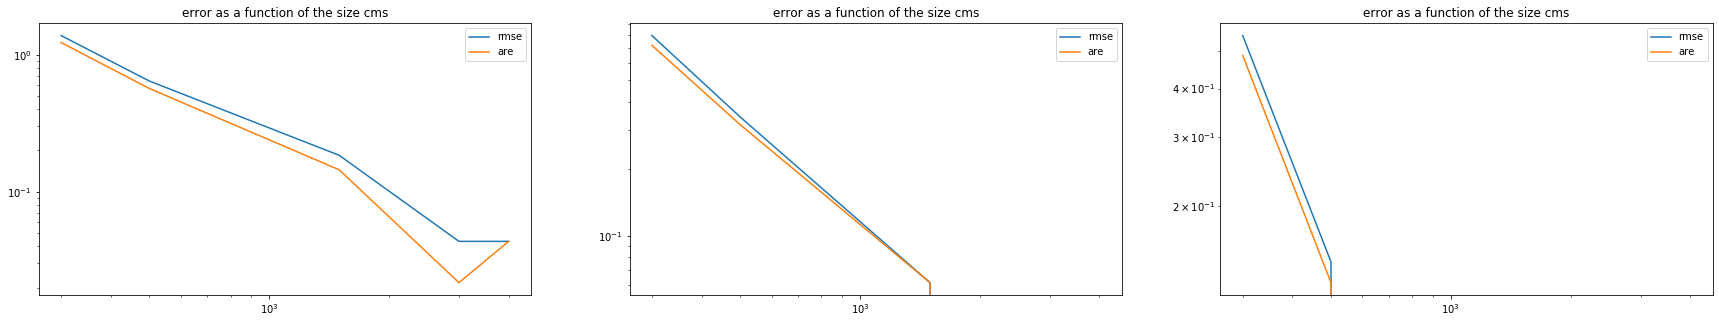

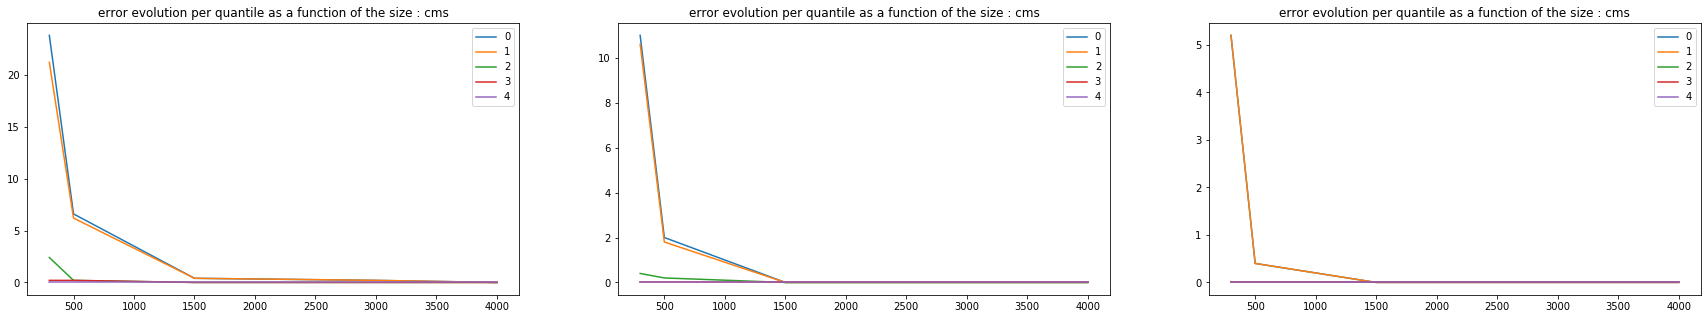

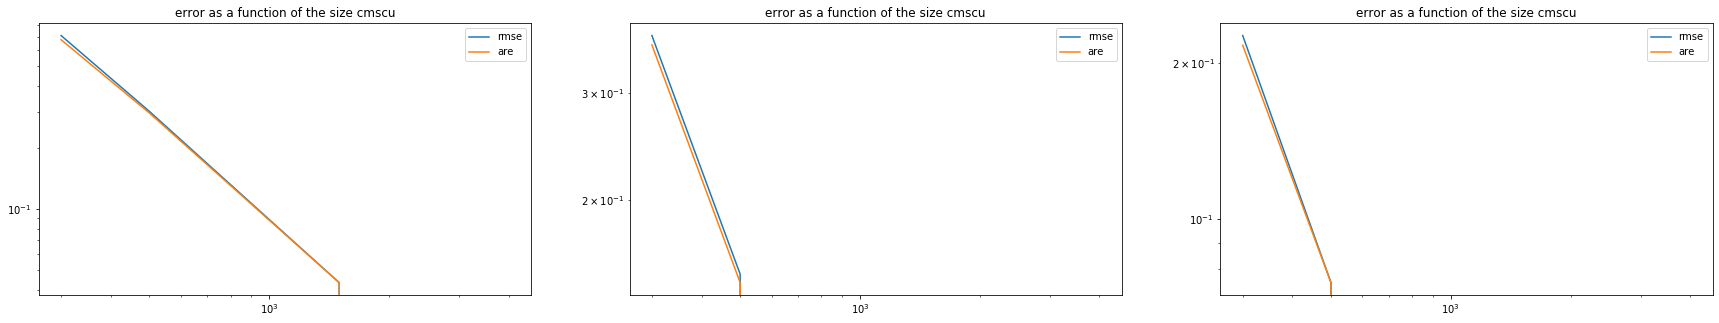

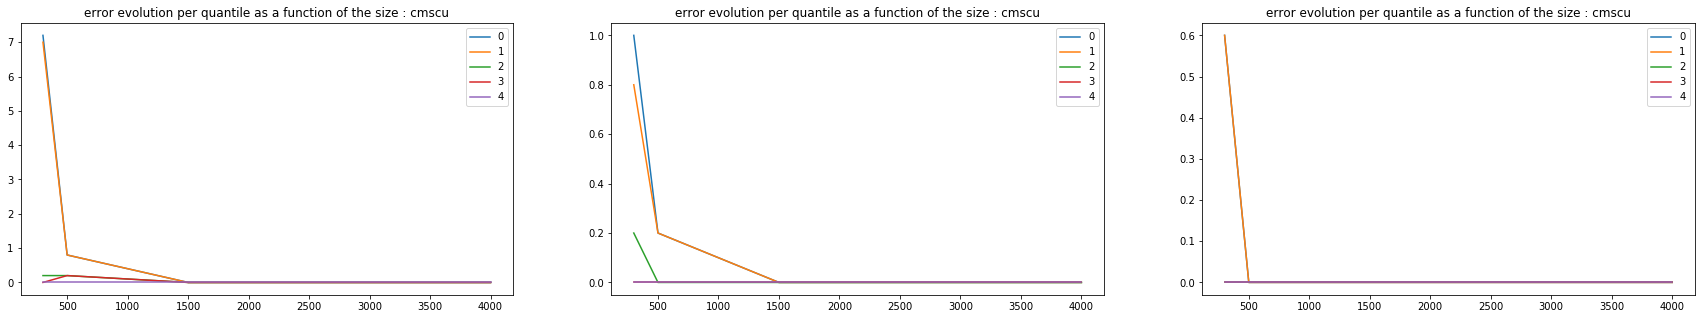

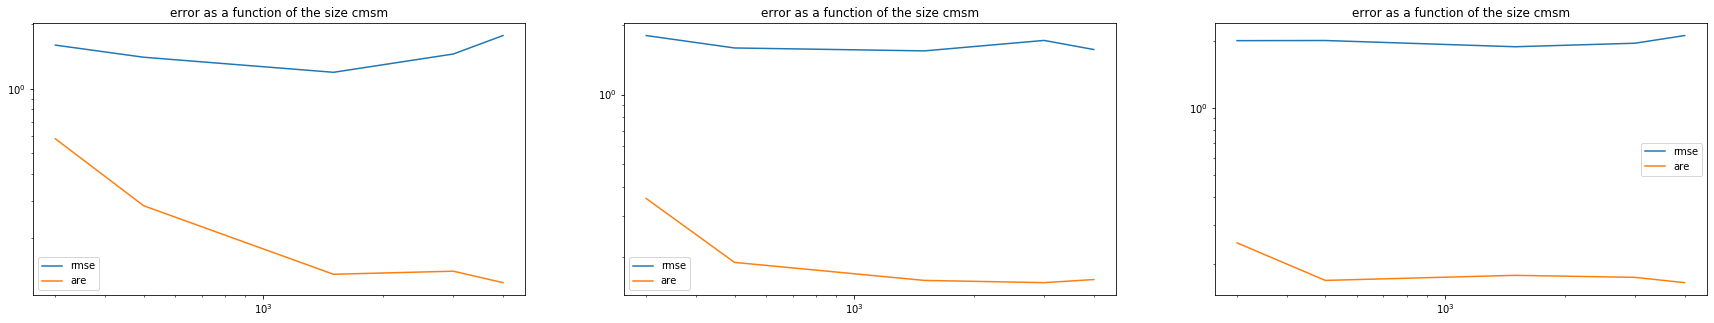

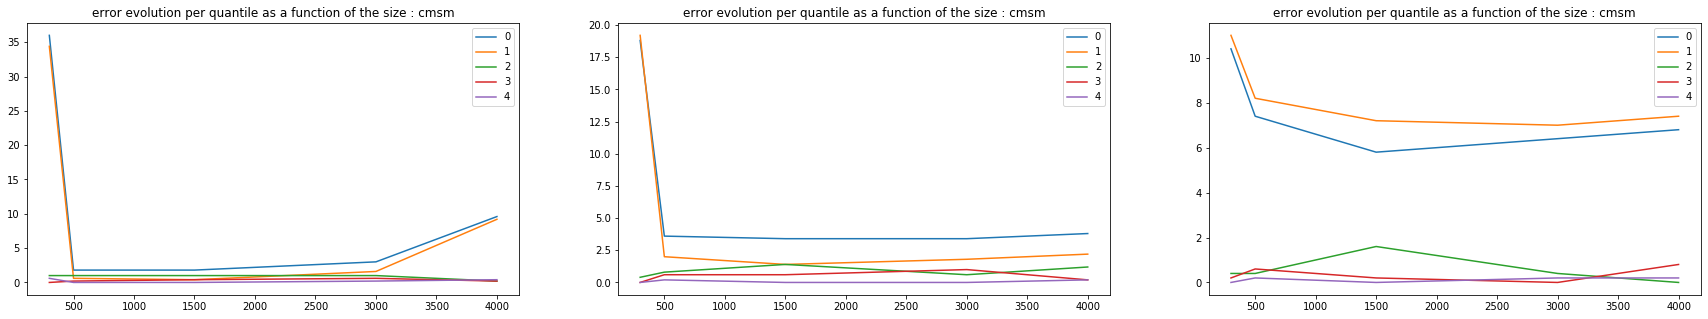

/home/mados/.local/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log10


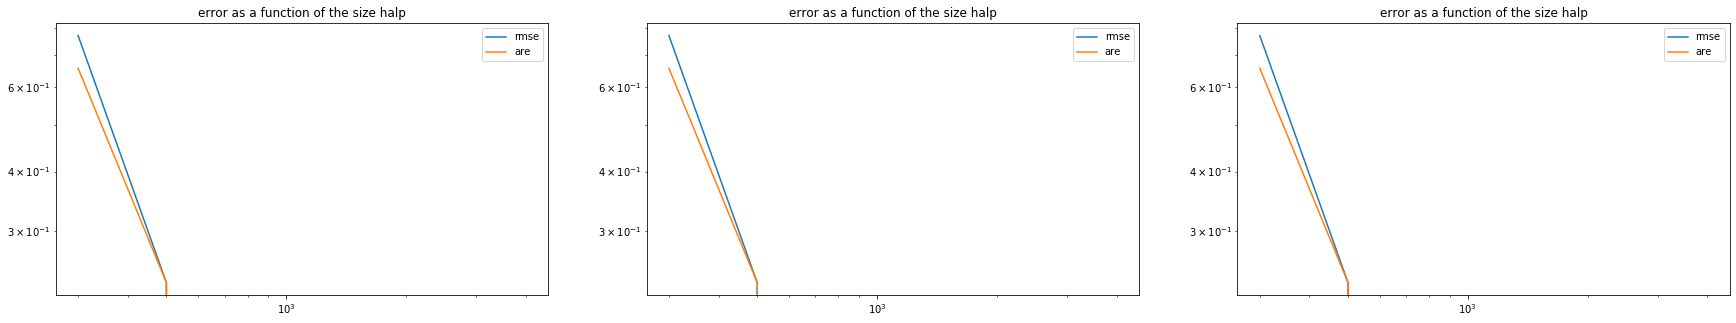

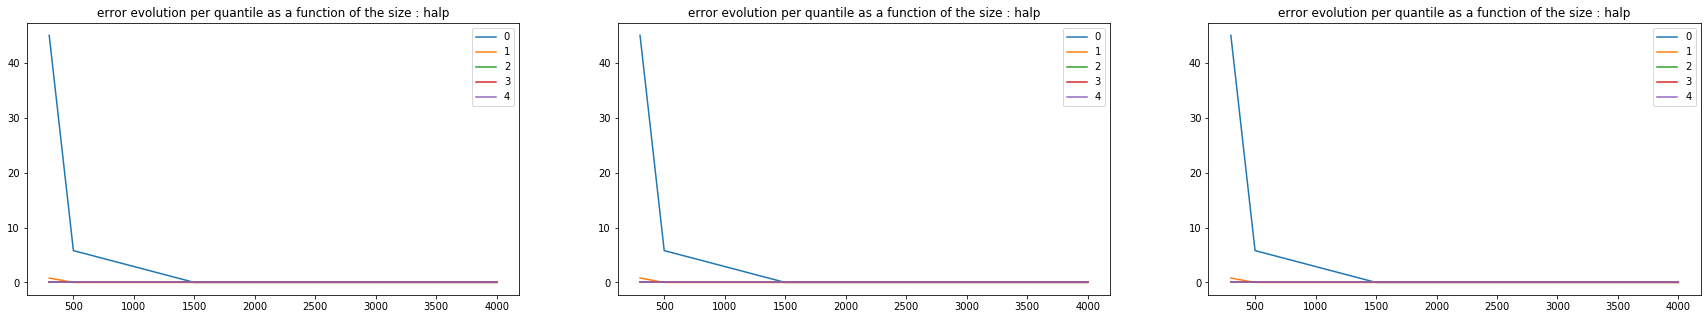

In [10]:
ds = [3,5,8]
ws = [300,500,1500,3000,4000]

toTests = ["cms", "cmscu", "cmsm", "halp"]
for toTest in toTests:
    graph_error(ws, ds, data, toTest)
    plt.show()

# 5 –Compter maintenant bigrammes+ unigrammes, grapher RMSE + variance sur la valeur PMI en la calculant pour tous les bigrammes, pour toutes les versions.

In [11]:
def proba_word(count_word, all_count): #calcule pa, pb, pab la probabilité d'un mot
    return count_word/all_count

def pmi(pair, all_count, cnt_bi, cnt_uni):
    a, b = pair.split(" ")
    pa = proba_word(max(1,cnt_uni.get_word_count(a)), all_count) #le max est un hack qui empéche les divisions par 0 (le compteur s'est trompé)
    pb = proba_word(max(1,cnt_uni.get_word_count(b)),all_count)
    pab = proba_word(max(1,cnt_bi.get_word_count(pair)), all_count)
    return np.log10(pab/pa*pb) #le pmi
    

def graph_variance_pmi(ws, ds, data, toTest):
    
    fig, axs  = plt.subplots(1,len(ds), figsize=(30,5))
    
    bigrams = list(map(' '.join,list(zip(data, data[1:]))))
    unique_bigrams = np.unique(bigrams)
    
    for d, ax in zip(ds, axs):
        variance_pmi = list()
        
        for w in ws:
            cms_uni = make_a_cms(w,d, data, toTest)
            cms_bi = make_a_cms(w,d, bigrams, toTest)
            pmi_predictions_bigram = np.vectorize(lambda pw: pmi(pw , len(unique_bigrams), cms_bi, cms_uni))(unique_bigrams)
            variance =  np.var(pmi_predictions_bigram)
            variance_pmi.append(variance)
            
            
        
        ax.plot(ws, variance_pmi, label="variance pmi")
        ax.set_title("variance of the pmi as a function of the size "+toTest)
        ax.legend()


/home/mados/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys
/home/mados/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
/home/mados/.local/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log10


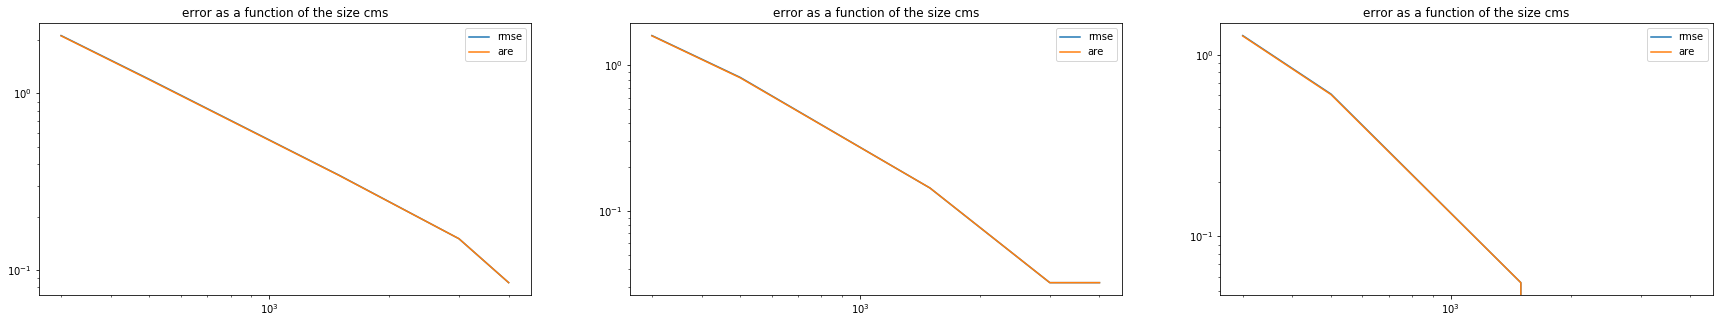

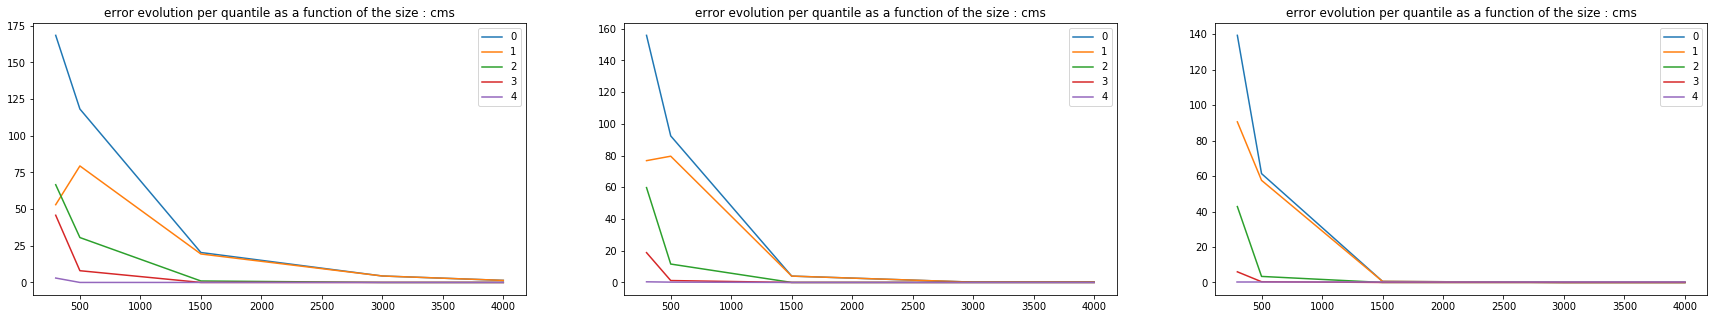

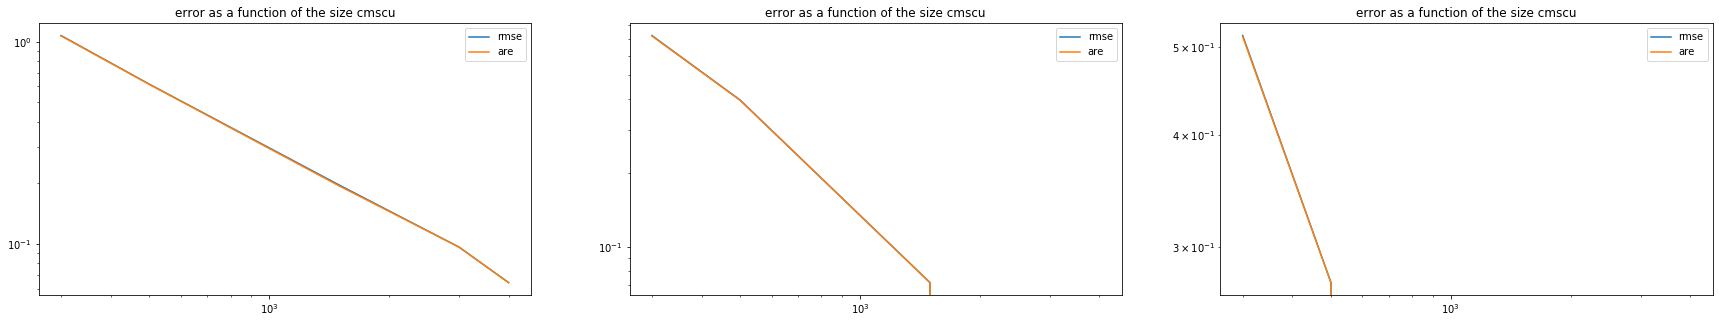

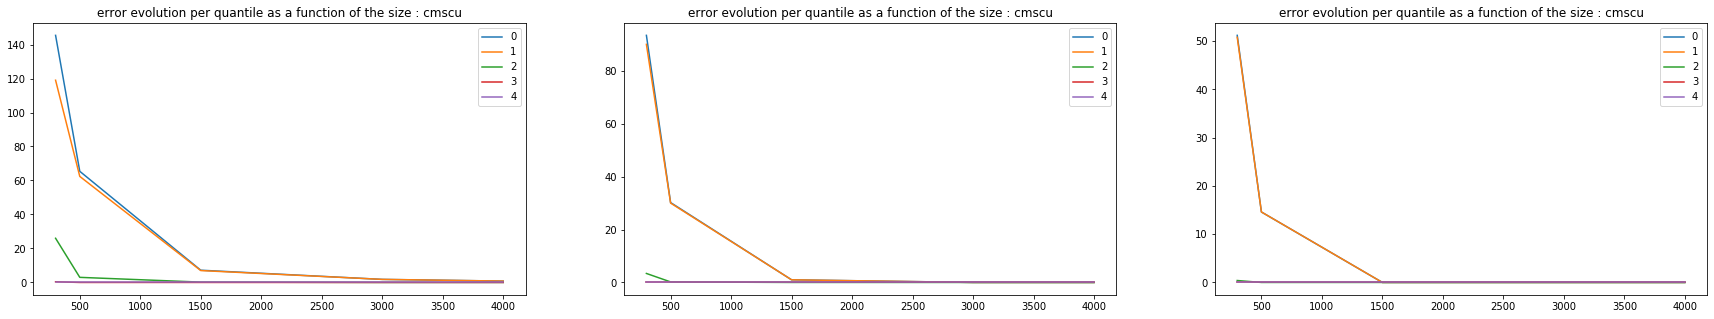

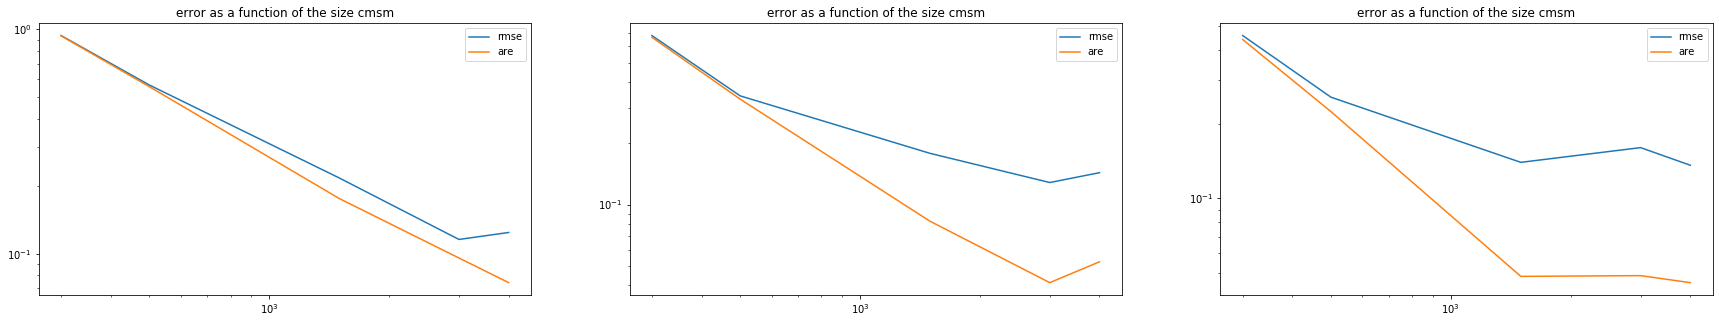

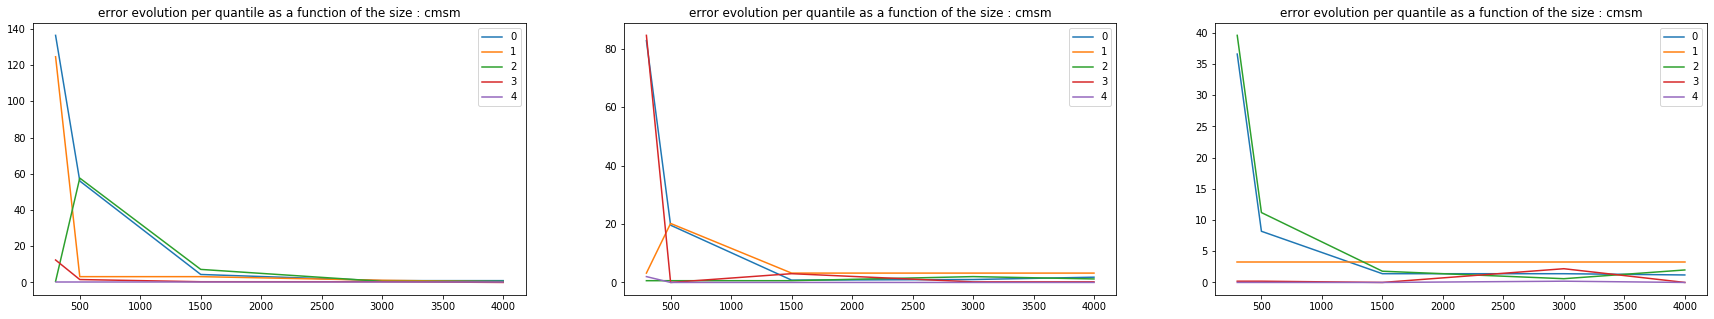

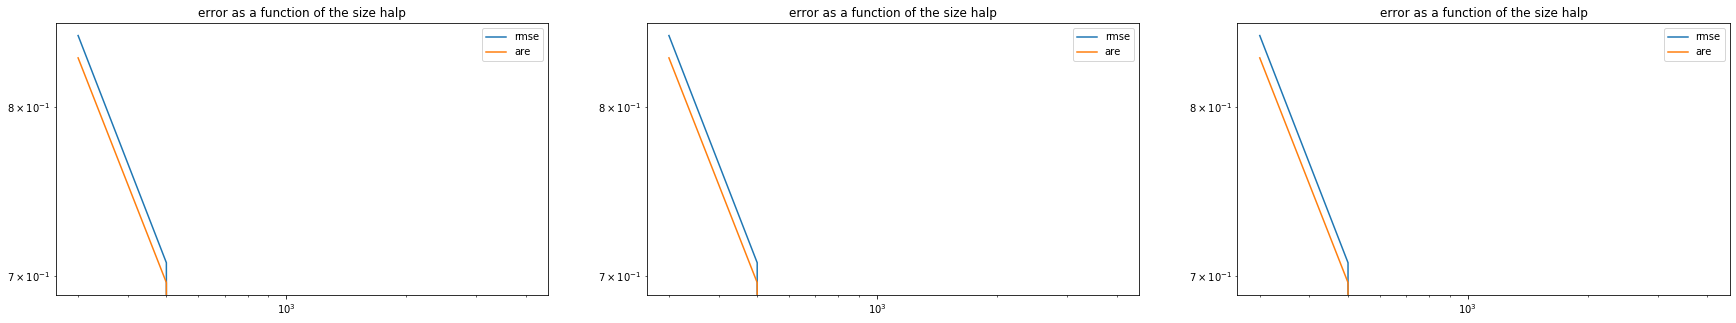

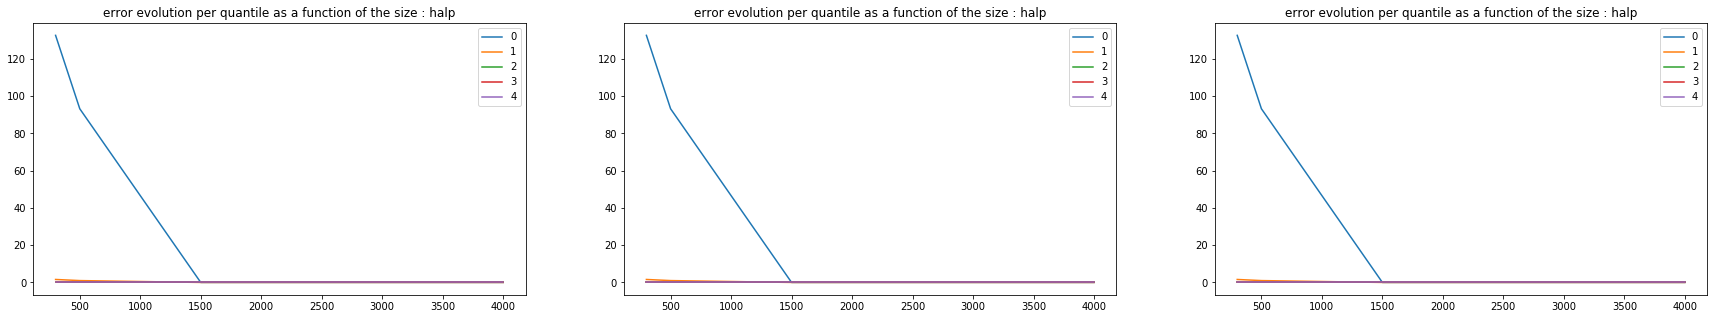

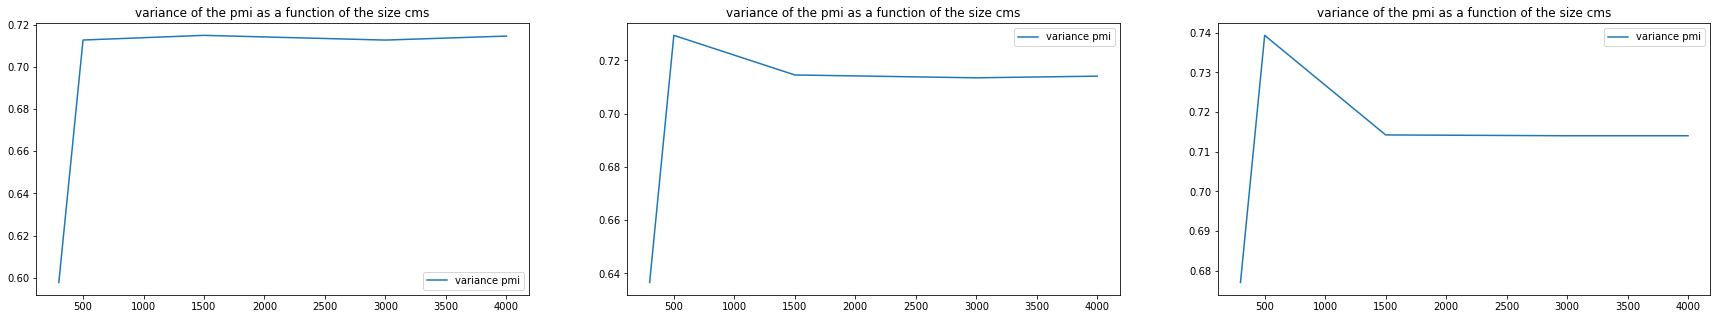

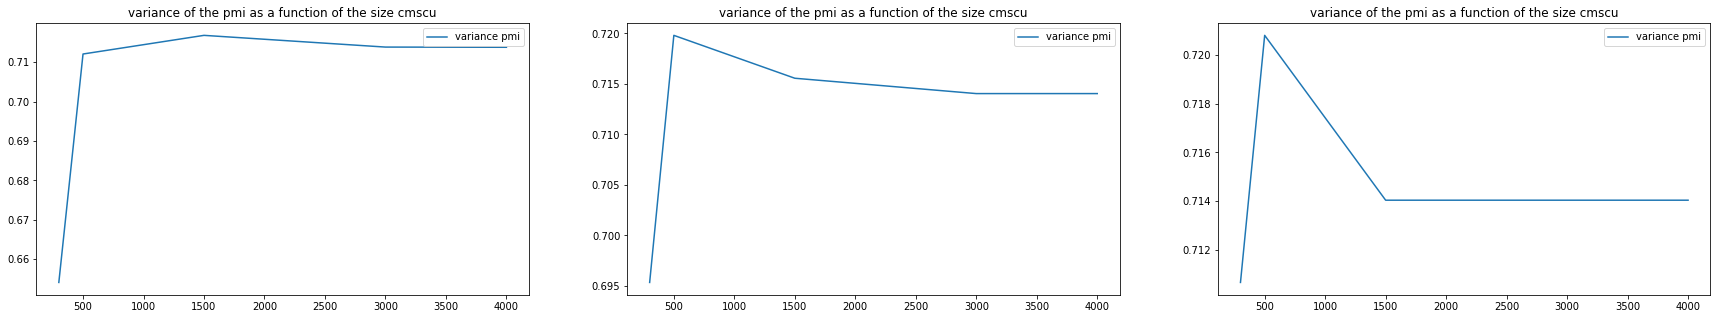

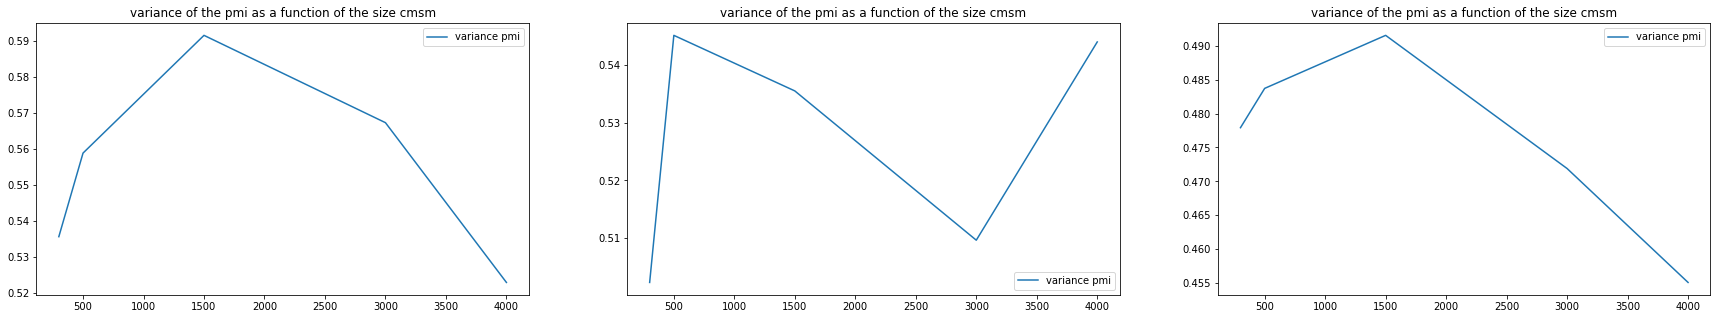

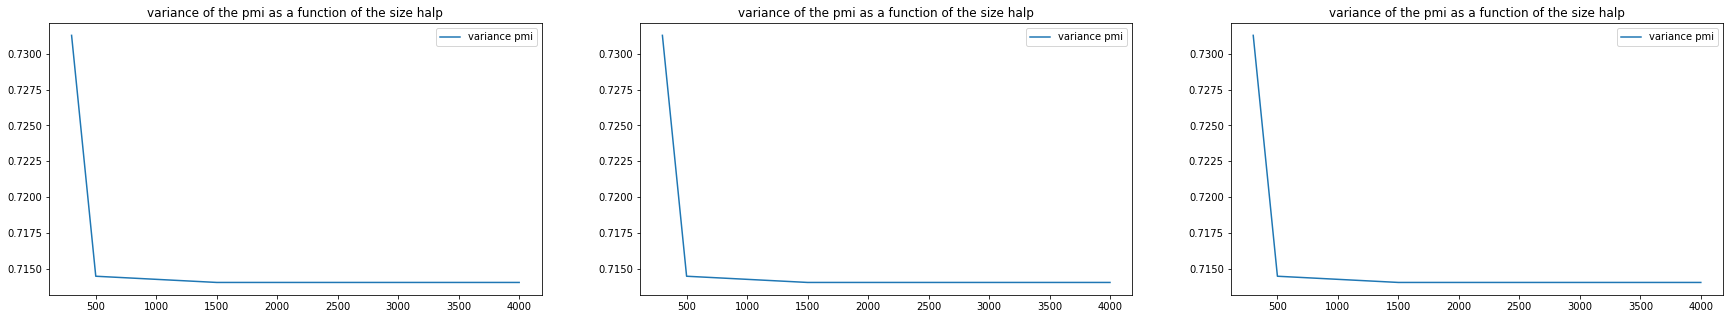

In [12]:
ds = [3,5,8]
ws = [300,500,1500,3000,4000]

bigrams = list(map(' '.join,list(zip(data, data[1:]))))

toTests = ["cms", "cmscu", "cmsm", "halp"]
for toTest in toTests:
    graph_error(ws, ds, bigrams, toTest)

    
for toTest in toTests:
    graph_variance_pmi(ws, ds, data, toTest)
    plt.show()

In [61]:
# Avec les compteurs de Morris cela semble ne pas trop bien marcher.
# Je soupçonne un bug
# Je laisse cette cellule pour observer le phoenoméne

unique_words = np.unique(data) #Get all unique words
cnt = Counter(data)
ground_truth = np.array(tuple(map(lambda w : cnt[w], unique_words)))

cms = countMinSketchMorris(w=30000, d=8)

for w in data:
    cms.insert_word(w)
    
predictions = np.vectorize(cms.get_word_count)(unique_words)
print(predictions)
print(ground_truth)
print(RMSE_sum(predictions, ground_truth))
print(ARE_sum(predictions, ground_truth))

[12.  1.  4.  1.  1.  1.  2.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  6.  1. 12.  1.  1.  1.  2.  1.  6.  1.  1.  8.  1.  1.  2.  1.
  1.  1.  6.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  3.  1.  1.  1.  1.  4.  1.  2.  1.  1.  2.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  2.  2.  1.  1.  1.  1.  1.  1.  1.  1.  2.  1.  1.  1.  1.
  1.  1.  4.  1.  2.  1.  1.  1.  2.  1.  1.  1.  1.  1.  2.  1.  2.  1.
  1.  1.  1.  1.  1.  2.  1.  2.  1.  1.  1.  1.  1.  1.  6.  1.  1.  1.
  1.  1.  1.  3.  1.  1.  1.  1.  1.  2.  1.  1.  1.  1.  1.  2.  1.  1.
  1.  1.  2.  1.  1.  1.  1.  1.  1.  2.  3.  1.  1.  3.  1.  1.  1.  2.
  1.  1.  1.  1.  1.  2. 10.  2.  1. 10.  1.  1.  1.  1.  1.  1.  1.  1.
  2.  1. 10. 12.  1.  1.  1.  1.  1.  1.  1.  1.  1.  2.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  2.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  2.  1